In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import libraries - PyTorch

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tempfile import TemporaryDirectory
import time

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.models import resnet101, resnet50, resnet18
import torchvision.transforms as transforms
import torchvision.transforms as tt
from torchvision.datasets import CIFAR100 
from torchvision import datasets, models, transforms
from torchinfo import summary

from tqdm import tqdm

In [34]:
torch.manual_seed(0)

In [ ]:
!rm -rf /kaggle/working/*
!rm -rf /kaggle/working/models/*

In [35]:
os.makedirs("/kaggle/working/models",exist_ok=True)

In [36]:
os.makedirs("/kaggle/working/aftermodels",exist_ok=True)

# Compute stats

In [ ]:
stat_train_data = CIFAR100(download=True, root="./data", transform=tt.ToTensor())
stat_test_data = CIFAR100(root="./data", train=False, transform=tt.ToTensor())

In [ ]:
imgs_train = torch.stack([img_t for img_t ,_ in stat_train_data],dim=3)
imgs_test = torch.stack([img_t for img_t ,_ in stat_test_data],dim=3)
imgs = torch.cat((imgs_train, imgs_test), 3)
mean = imgs.view(3,-1).mean(dim=1).numpy()
std = imgs.view(3, -1).std(dim=1).numpy()
print(mean, std)

# Stat and transform

In [5]:
stats=((0.50736207, 0.4866896, 0.44108862), (0.26748815, 0.2565931, 0.2763085))
train_transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomCrop(32, padding=4, padding_mode="reflect"),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Import dataset 100 classes

In [6]:
train_data = CIFAR100(download=True, root="./data", transform=train_transform)
test_data = CIFAR100(root="./data", train=False, transform=test_transform)

100%|██████████| 169001437/169001437 [00:02<00:00, 80375487.84it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [7]:
batch_size=128
num_work=4
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)
test_dl = DataLoader(test_data, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)

# Import dataset 20 classes

In [8]:
class CIFAR100Coarse(torch.utils.data.Dataset):
    def __init__(self, cifar100_dataset) ->None:
        self.cifar100_dataset = cifar100_dataset
        
        # Define the mapping from fine labels to coarse labels
        self.fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }
        
        # Mapping from superclass labels to superclass names
        self.coarse_label_names = {
            0: 'aquatic mammals',
            1: 'fish',
            2: 'flowers',
            3: 'food containers',
            4: 'fruit and vegetables',
            5: 'household electrical devices',
            6: 'household furniture',
            7: 'insects',
            8: 'large carnivores',
            9: 'large man-made outdoor things',
            10: 'large natural outdoor scenes',
            11: 'large omnivores and herbivores',
            12: 'medium-sized mammals',
            13: 'non-insect invertebrates',
            14: 'people',
            15: 'reptiles',
            16: 'small mammals',
            17: 'trees',
            18: 'vehicles 1',
            19: 'vehicles 2'
        }

    def __getitem__(self, index):
        img, target = self.cifar100_dataset[index]

        # Convert fine label to coarse label
        target = self.fine_to_coarse[target]

        return img, target

    def __len__(self):
        return len(self.cifar100_dataset)

    def get_coarse_label_name(self, label):
        return self.coarse_label_names[label]

    def get_all_coarse_label_names(self):
        return self.coarse_label_names.values()


In [37]:
train_data_20=CIFAR100Coarse(train_data)
test_data_20=CIFAR100Coarse(test_data)

In [38]:
def get_superclass(targets):
    fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }
    targets_cpu=targets.cpu().numpy()
    supertargets=[fine_to_coarse[target] for target in targets_cpu]
    supertargets=torch.tensor(supertargets, dtype=torch.int64, device=targets.device)
    return supertargets

In [39]:
fine_to_coarse={
            0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3,
            10: 3, 11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7,
            19: 11, 20: 6, 21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15,
            28: 3, 29: 15, 30: 0, 31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16,
            37: 9, 38: 11, 39: 5, 40: 5, 41: 19, 42: 8, 43: 8, 44: 15, 45: 13,
            46: 14, 47: 17, 48: 18, 49: 10, 50: 16, 51: 4, 52: 17, 53: 4, 54: 2,
            55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10, 61: 3, 62: 2, 63: 12,
            64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2, 71: 10, 72: 0,
            73: 1, 74: 16, 75: 12, 76: 9, 77: 13, 78: 15, 79: 13, 80: 16, 81: 19,
            82: 2, 83: 4, 84: 6, 85: 19, 86: 5, 87: 5, 88: 8, 89: 19, 90: 18, 91: 1,
            92: 2, 93: 15, 94: 6, 95: 0, 96: 17, 97: 8, 98: 14, 99: 13
        }

In [41]:
def get_superclass_logits(outputs, fine_to_coarse):
    num_superclasses = len(set(fine_to_coarse.values())) # 20 superclass
    superclass_logits = torch.zeros((outputs.size(0), num_superclasses)).to(outputs.device)
    for fine_class, coarse_class in fine_to_coarse.items():
        superclass_logits[:, coarse_class] += outputs[:, fine_class] 
    return superclass_logits

In [42]:
batch_size=128
num_work=4
train_dl_20 = DataLoader(train_data_20, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)
test_dl_20 = DataLoader(test_data_20, batch_size, shuffle=True, num_workers=num_work, pin_memory=True)

## Print number of items for each superclass

In [ ]:
train_classes_20={}

for img,label in train_data_20:
    class_name=train_data_20.coarse_label_names[label]
    if class_name not in train_classes_20:
        train_classes_20[class_name]=1
    else:
        train_classes_20[class_name]+=1

In [ ]:
train_classes_20

# Device - GPU cuda

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [ ]:
def make_model(num_classes=20):
    model=resnet18(weights=None)
    model.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
    model.maxpool = nn.Identity()
    num_in_ftrs=model.fc.in_features
    num_out_ftrs=model.fc.out_features
    model.fc=nn.Linear(num_in_ftrs,num_classes)
    return model

In [90]:
model=resnet18(weights=None)
model.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
model.maxpool = nn.Identity()
num_in_ftrs=model.fc.in_features
num_out_ftrs=model.fc.out_features

In [91]:
num_classes=100
model.fc=nn.Linear(num_in_ftrs,num_classes)

In [92]:
model=model.to(device)

In [93]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [18]:
summary(model,(128,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 100]                --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─ReLU: 1-3                              [128, 64, 32, 32]         --
├─Identity: 1-4                          [128, 64, 32, 32]         --
├─Sequential: 1-5                        [128, 64, 32, 32]         --
│    └─BasicBlock: 2-1                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-3                    [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-4                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-5             [128, 64, 32, 32]         128
│    │    └─ReLU: 3-6                    [128, 64, 32, 32]         --
│

# Optimizer, scheduler, criterion

In [94]:
# For optimizer:
max_lr=5e-2
momentum=0.9
weight_decay = 5e-4 
criterion_class = nn.CrossEntropyLoss()
criterion_superclass = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 25], gamma=0.1)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,55,60,80,120,140], gamma=0.1)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,80,120,140], gamma=0.2)

In [95]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, min_lr=5e-05, verbose=True)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.3)

# Training and validation loop

In [96]:
num_epochs=300

In [ ]:
!rm -rf /kaggle/working/models/*

In [25]:
    for batch_idx, (inputs, targets) in enumerate(train_dl):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        print(outputs.size())
        print(outputs[0])
        print(torch.argmax(outputs[0]))
        # First loss for normal classes
        loss_class = criterion_class(outputs, targets)
        # Changing the output and targets into superclasses and loss for superclasses
        super_targets=get_superclass(targets)
        outputs_superclass=get_superclass_logits(outputs, fine_to_coarse)
        print(outputs_superclass.size())
        print(outputs_superclass[0])
        print(torch.argmax(outputs_superclass[0]))
        
        
        loss_superclass=criterion_superclass(outputs_superclass,super_targets)
        
        # Sum loss function
        loss=loss_class+loss_superclass
        break

torch.Size([128, 100])
tensor([ 0.8376,  0.6942, -0.1024, -0.9487, -0.8250,  0.6479,  0.8322, -0.4381,
         0.5360, -0.0619, -0.7053,  0.4470,  0.1035, -0.2056,  0.0135,  0.9355,
         1.0547, -0.0802, -1.1413,  0.0753, -0.3321, -0.2254, -0.1519,  0.1125,
         0.2281, -0.4281,  0.2159,  1.0451, -0.7019, -0.6949,  0.9760,  1.4351,
        -1.0068, -0.9693, -1.7200,  0.8763,  0.8376,  0.2736,  1.4148, -0.3775,
         0.2546, -0.0961,  0.3980, -0.9084,  0.7617,  0.0088, -0.2845, -1.3432,
        -0.7838, -0.8538,  0.2867,  0.3438, -1.1419, -1.0494, -0.6548, -0.8230,
        -0.7822,  0.7746, -0.7293,  0.1443,  0.0750,  0.8942, -1.1395,  0.3305,
        -0.4966,  0.4535,  0.0544, -1.0685, -0.8026,  0.0900, -1.5918, -2.4022,
         0.1232,  1.9588, -0.0139, -0.9211, -1.3188, -0.8549, -0.5399,  0.8168,
        -0.3122,  0.5297,  0.2895,  1.4297, -0.3240,  1.0606,  0.2818, -2.6332,
        -0.3728, -1.2851,  1.2004, -0.2224,  0.6713, -0.1274,  0.8875, -0.6126,
         0.5417, 

In [32]:
print(outputs_single_row[0],outputs_single_row[51],outputs_single_row[53],outputs_single_row[57],outputs_single_row[83])
outputs_single_row[0]+outputs_single_row[51]+outputs_single_row[53]+outputs_single_row[57]+outputs_single_row[83]

tensor(0.8376) tensor(0.3438) tensor(-1.0494) tensor(0.7746) tensor(1.4297)


tensor(2.3363)

# Train for 100 classes with aditional criterion for 20 superclasses

In [97]:
train_loss=[]
train_loss_class=[]
train_loss_superclass=[]
train_acc=[]
train_acc_super=[]
test_loss=[]
test_loss_class=[]
test_loss_superclass=[]
test_acc=[]
test_acc_super=[]
alpha=0.25
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_loss_class=0.0
    total_loss_superclass=0.0
    correct_predictions = 0
    total_samples = 0
    correct_predictions_super=0
    total_samples_super=0

    data_loader = tqdm(train_dl, total=len(train_dl), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        # First loss for normal classes
        loss_class = criterion_class(outputs, targets)
        # Changing the output and targets into superclasses and loss for superclasses
        super_targets=get_superclass(targets)
        outputs_superclass=get_superclass_logits(outputs, fine_to_coarse)
        loss_superclass=criterion_superclass(outputs_superclass,super_targets)
        
        # Sum loss function
        loss=alpha*loss_class+(1-alpha)*loss_superclass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_loss_class+=loss_class.item()
        total_loss_superclass+=loss_superclass.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)
        
        _,predicted_superclass=outputs_superclass.max(1)
        correct_predictions_super+=predicted_superclass.eq(super_targets).sum().item()
        total_samples_super+=super_targets.size(0)
        

        # Progress bar description
        data_loader.set_postfix(loss=total_loss / (batch_idx + 1), Loss_class=total_loss_class/(batch_idx + 1), Loss_superclass=total_loss_superclass/(batch_idx + 1),
                                accuracy=correct_predictions / total_samples, accuracy_super=correct_predictions_super/total_samples_super)

    average_loss = total_loss / len(train_dl)
    average_loss_class=total_loss_class/(batch_idx + 1)
    average_loss_superclass=total_loss_superclass/(batch_idx + 1)
    accuracy = correct_predictions / total_samples
    accuracy_super=correct_predictions_super/total_samples_super

    train_loss.append(average_loss)
    train_loss_class.append(average_loss_class)
    train_loss_superclass.append(average_loss_superclass)
    train_acc.append(accuracy)
    train_acc_super.append(accuracy_super)
    
    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    total_loss_class_test, total_loss_superclass_test=0,0
    correct_test_super, total_test_super =0,0
    with torch.no_grad():
        for (inputs, targets) in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss_class = criterion_class(outputs, targets)
            super_targets=get_superclass(targets)
            outputs_superclass=get_superclass_logits(outputs, fine_to_coarse)
            loss_superclass=criterion_superclass(outputs_superclass,super_targets)
            
            loss=loss_class+loss_superclass 
            total_loss_test += loss.item()
            total_loss_class_test +=loss_class.item()
            total_loss_superclass_test +=loss_superclass.item()
            
            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)
            
            _,predicted_superclass=outputs_superclass.max(1)
            correct_test_super+=predicted_superclass.eq(super_targets).sum().item()
            total_test_super+=super_targets.size(0)

        accuracy_test = correct_test / total_test
        accuracy_test_super=correct_test_super/total_test_super
        average_loss_test = total_loss_test / len(test_dl)
        average_loss_class_test=total_loss_class_test/(batch_idx + 1)
        average_loss_superclass_test=total_loss_superclass_test/(batch_idx + 1)
   
    test_loss.append(average_loss_test)
    test_loss_class.append(average_loss_class_test)
    test_loss_superclass.append(average_loss_superclass_test)
    test_acc.append(accuracy_test)
    test_acc_super.append(accuracy_test_super)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f},Loss_class: {average_loss_class:.4f},Loss_superclass: {average_loss_superclass:.4f},Accuracy: {accuracy * 100:.2f}%, Accuracy_super: {accuracy_super * 100:.2f}%, Loss_test: {average_loss_test:.4f},Loss_test_class: {average_loss_class_test:.4f},Loss_test_superclass: {average_loss_superclass_test:.4f}, Accuracy_test: {100 * accuracy_test:.2f} %, Accuracy_test_super: {100 * accuracy_test_super:.2f} %')


#     if epoch%5==0:
#         model_save_path = '/kaggle/working/resnet_cifar100_100classes_e' + str(epoch+1) + '.pth'
#         training_stats = {
#           'epoch': epoch+1,
#           'model_state_dict': model.state_dict(),
#           'optimizer_state_dict': optimizer.state_dict(),
#           'scheduler_state_dict': scheduler.state_dict(),
#           'loss': average_loss,
#           'accuracy': accuracy,
#           'test_accuracy': accuracy_test,
#           'test_loss': average_loss_test,
#           'learning_rate': optimizer.param_groups[0]["lr"]
#         }
    model_save_path = '/kaggle/working/models/cifar100_doublecrit_25_ep' + str(epoch+1) + '.pth'
    training_stats = {
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': average_loss,
        'loss_class': average_loss_class,
        'loss_superclass':average_loss_superclass,
        'accuracy': accuracy,
        'accuracy_super': accuracy_super,
        'test_accuracy': accuracy_test,
        'test_accuracy_super':accuracy_test_super,
        'test_loss': average_loss_test,
        'test_loss_class':average_loss_class_test,
        'test_loss_superclass':average_loss_superclass_test,
        'learning_rate': optimizer.param_groups[0]["lr"]
    }
    scheduler.step(average_loss_test)
    torch.save(training_stats, model_save_path)

Epoch [1/300]: 100%|██████████| 391/391 [00:35<00:00, 10.99it/s, Loss_class=4.37, Loss_superclass=2.71, accuracy=0.0617, accuracy_super=0.197, loss=3.13]


Epoch [1/300] - Loss: 3.1253,Loss_class: 4.3691,Loss_superclass: 2.7106,Accuracy: 6.17%, Accuracy_super: 19.67%, Loss_test: 6.5399,Loss_test_class: 0.8407,Loss_test_superclass: 0.4806, Accuracy_test: 9.89 %, Accuracy_test_super: 26.32 %


Epoch [2/300]: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s, Loss_class=4.06, Loss_superclass=2.26, accuracy=0.114, accuracy_super=0.298, loss=2.71]


Epoch [2/300] - Loss: 2.7136,Loss_class: 4.0636,Loss_superclass: 2.2635,Accuracy: 11.37%, Accuracy_super: 29.80%, Loss_test: 5.9920,Loss_test_class: 0.7936,Loss_test_superclass: 0.4171, Accuracy_test: 14.94 %, Accuracy_test_super: 35.48 %


Epoch [3/300]: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s, Loss_class=3.81, Loss_superclass=2.04, accuracy=0.159, accuracy_super=0.367, loss=2.48]


Epoch [3/300] - Loss: 2.4829,Loss_class: 3.8141,Loss_superclass: 2.0392,Accuracy: 15.89%, Accuracy_super: 36.68%, Loss_test: 5.6363,Loss_test_class: 0.7415,Loss_test_superclass: 0.3972, Accuracy_test: 18.50 %, Accuracy_test_super: 39.64 %


Epoch [4/300]: 100%|██████████| 391/391 [00:35<00:00, 10.87it/s, Loss_class=3.57, Loss_superclass=1.85, accuracy=0.205, accuracy_super=0.423, loss=2.28]


Epoch [4/300] - Loss: 2.2814,Loss_class: 3.5724,Loss_superclass: 1.8510,Accuracy: 20.46%, Accuracy_super: 42.35%, Loss_test: 5.1137,Loss_test_class: 0.6947,Loss_test_superclass: 0.3385, Accuracy_test: 24.01 %, Accuracy_test_super: 47.44 %


Epoch [5/300]: 100%|██████████| 391/391 [00:35<00:00, 10.86it/s, Loss_class=3.29, Loss_superclass=1.65, accuracy=0.254, accuracy_super=0.485, loss=2.06]


Epoch [5/300] - Loss: 2.0608,Loss_class: 3.2851,Loss_superclass: 1.6527,Accuracy: 25.37%, Accuracy_super: 48.52%, Loss_test: 4.7014,Loss_test_class: 0.6291,Loss_test_superclass: 0.3208, Accuracy_test: 28.84 %, Accuracy_test_super: 50.30 %


Epoch [6/300]: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s, Loss_class=3, Loss_superclass=1.48, accuracy=0.311, accuracy_super=0.534, loss=1.86]   


Epoch [6/300] - Loss: 1.8575,Loss_class: 2.9993,Loss_superclass: 1.4769,Accuracy: 31.13%, Accuracy_super: 53.36%, Loss_test: 4.1271,Loss_test_class: 0.5665,Loss_test_superclass: 0.2674, Accuracy_test: 34.90 %, Accuracy_test_super: 58.30 %


Epoch [7/300]: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s, Loss_class=2.74, Loss_superclass=1.32, accuracy=0.36, accuracy_super=0.581, loss=1.68] 


Epoch [7/300] - Loss: 1.6786,Loss_class: 2.7405,Loss_superclass: 1.3246,Accuracy: 36.02%, Accuracy_super: 58.10%, Loss_test: 3.8844,Loss_test_class: 0.5312,Loss_test_superclass: 0.2537, Accuracy_test: 38.55 %, Accuracy_test_super: 60.11 %


Epoch [8/300]: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s, Loss_class=2.54, Loss_superclass=1.21, accuracy=0.402, accuracy_super=0.615, loss=1.54]


Epoch [8/300] - Loss: 1.5428,Loss_class: 2.5374,Loss_superclass: 1.2113,Accuracy: 40.19%, Accuracy_super: 61.52%, Loss_test: 3.6857,Loss_test_class: 0.4984,Loss_test_superclass: 0.2463, Accuracy_test: 42.48 %, Accuracy_test_super: 61.38 %


Epoch [9/300]: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s, Loss_class=2.36, Loss_superclass=1.1, accuracy=0.44, accuracy_super=0.649, loss=1.42]  


Epoch [9/300] - Loss: 1.4152,Loss_class: 2.3579,Loss_superclass: 1.1010,Accuracy: 43.97%, Accuracy_super: 64.89%, Loss_test: 3.3738,Loss_test_class: 0.4594,Loss_test_superclass: 0.2222, Accuracy_test: 46.12 %, Accuracy_test_super: 64.92 %


Epoch [10/300]: 100%|██████████| 391/391 [00:35<00:00, 10.96it/s, Loss_class=2.22, Loss_superclass=1.03, accuracy=0.47, accuracy_super=0.673, loss=1.32] 


Epoch [10/300] - Loss: 1.3249,Loss_class: 2.2220,Loss_superclass: 1.0258,Accuracy: 46.99%, Accuracy_super: 67.26%, Loss_test: 3.1673,Loss_test_class: 0.4309,Loss_test_superclass: 0.2090, Accuracy_test: 48.46 %, Accuracy_test_super: 67.33 %


Epoch [11/300]: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s, Loss_class=2.1, Loss_superclass=0.957, accuracy=0.495, accuracy_super=0.696, loss=1.24] 


Epoch [11/300] - Loss: 1.2419,Loss_class: 2.0965,Loss_superclass: 0.9570,Accuracy: 49.50%, Accuracy_super: 69.59%, Loss_test: 3.0130,Loss_test_class: 0.4146,Loss_test_superclass: 0.1941, Accuracy_test: 50.28 %, Accuracy_test_super: 69.61 %


Epoch [12/300]: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s, Loss_class=1.99, Loss_superclass=0.909, accuracy=0.516, accuracy_super=0.709, loss=1.18]


Epoch [12/300] - Loss: 1.1805,Loss_class: 1.9939,Loss_superclass: 0.9094,Accuracy: 51.55%, Accuracy_super: 70.88%, Loss_test: 2.8669,Loss_test_class: 0.3946,Loss_test_superclass: 0.1846, Accuracy_test: 52.14 %, Accuracy_test_super: 71.00 %


Epoch [13/300]: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s, Loss_class=1.9, Loss_superclass=0.861, accuracy=0.534, accuracy_super=0.724, loss=1.12] 


Epoch [13/300] - Loss: 1.1211,Loss_class: 1.8998,Loss_superclass: 0.8615,Accuracy: 53.45%, Accuracy_super: 72.41%, Loss_test: 2.7900,Loss_test_class: 0.3797,Loss_test_superclass: 0.1840, Accuracy_test: 53.62 %, Accuracy_test_super: 71.53 %


Epoch [14/300]: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s, Loss_class=1.83, Loss_superclass=0.828, accuracy=0.549, accuracy_super=0.736, loss=1.08]


Epoch [14/300] - Loss: 1.0788,Loss_class: 1.8325,Loss_superclass: 0.8276,Accuracy: 54.88%, Accuracy_super: 73.56%, Loss_test: 2.9169,Loss_test_class: 0.3904,Loss_test_superclass: 0.1990, Accuracy_test: 52.90 %, Accuracy_test_super: 69.45 %


Epoch [15/300]: 100%|██████████| 391/391 [00:35<00:00, 11.02it/s, Loss_class=1.78, Loss_superclass=0.803, accuracy=0.563, accuracy_super=0.743, loss=1.05]


Epoch [15/300] - Loss: 1.0469,Loss_class: 1.7786,Loss_superclass: 0.8030,Accuracy: 56.34%, Accuracy_super: 74.25%, Loss_test: 2.6984,Loss_test_class: 0.3639,Loss_test_superclass: 0.1813, Accuracy_test: 55.67 %, Accuracy_test_super: 71.70 %


Epoch [16/300]: 100%|██████████| 391/391 [00:35<00:00, 11.01it/s, Loss_class=1.71, Loss_superclass=0.762, accuracy=0.578, accuracy_super=0.757, loss=0.999]


Epoch [16/300] - Loss: 0.9993,Loss_class: 1.7127,Loss_superclass: 0.7615,Accuracy: 57.78%, Accuracy_super: 75.69%, Loss_test: 2.6162,Loss_test_class: 0.3518,Loss_test_superclass: 0.1768, Accuracy_test: 56.70 %, Accuracy_test_super: 73.13 %


Epoch [17/300]: 100%|██████████| 391/391 [00:35<00:00, 11.00it/s, Loss_class=1.68, Loss_superclass=0.752, accuracy=0.583, accuracy_super=0.757, loss=0.984]


Epoch [17/300] - Loss: 0.9837,Loss_class: 1.6783,Loss_superclass: 0.7522,Accuracy: 58.27%, Accuracy_super: 75.69%, Loss_test: 2.5792,Loss_test_class: 0.3473,Loss_test_superclass: 0.1738, Accuracy_test: 57.04 %, Accuracy_test_super: 73.79 %


Epoch [18/300]: 100%|██████████| 391/391 [00:35<00:00, 10.89it/s, Loss_class=1.63, Loss_superclass=0.724, accuracy=0.596, accuracy_super=0.766, loss=0.95] 


Epoch [18/300] - Loss: 0.9505,Loss_class: 1.6295,Loss_superclass: 0.7242,Accuracy: 59.59%, Accuracy_super: 76.63%, Loss_test: 2.6271,Loss_test_class: 0.3461,Loss_test_superclass: 0.1847, Accuracy_test: 56.96 %, Accuracy_test_super: 72.73 %


Epoch [19/300]: 100%|██████████| 391/391 [00:35<00:00, 10.90it/s, Loss_class=1.59, Loss_superclass=0.71, accuracy=0.604, accuracy_super=0.773, loss=0.931] 


Epoch [19/300] - Loss: 0.9307,Loss_class: 1.5917,Loss_superclass: 0.7103,Accuracy: 60.42%, Accuracy_super: 77.31%, Loss_test: 2.5046,Loss_test_class: 0.3357,Loss_test_superclass: 0.1704, Accuracy_test: 58.23 %, Accuracy_test_super: 74.32 %


Epoch [20/300]: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s, Loss_class=1.56, Loss_superclass=0.695, accuracy=0.612, accuracy_super=0.779, loss=0.911]


Epoch [20/300] - Loss: 0.9109,Loss_class: 1.5578,Loss_superclass: 0.6953,Accuracy: 61.22%, Accuracy_super: 77.91%, Loss_test: 2.5349,Loss_test_class: 0.3359,Loss_test_superclass: 0.1762, Accuracy_test: 58.08 %, Accuracy_test_super: 73.59 %


Epoch [21/300]: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s, Loss_class=1.52, Loss_superclass=0.669, accuracy=0.621, accuracy_super=0.784, loss=0.881]


Epoch [21/300] - Loss: 0.8811,Loss_class: 1.5161,Loss_superclass: 0.6695,Accuracy: 62.14%, Accuracy_super: 78.44%, Loss_test: 2.4505,Loss_test_class: 0.3241,Loss_test_superclass: 0.1710, Accuracy_test: 59.52 %, Accuracy_test_super: 74.50 %


Epoch [22/300]: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s, Loss_class=1.49, Loss_superclass=0.649, accuracy=0.626, accuracy_super=0.792, loss=0.859]


Epoch [22/300] - Loss: 0.8586,Loss_class: 1.4875,Loss_superclass: 0.6489,Accuracy: 62.64%, Accuracy_super: 79.18%, Loss_test: 2.4399,Loss_test_class: 0.3237,Loss_test_superclass: 0.1693, Accuracy_test: 59.39 %, Accuracy_test_super: 75.19 %


Epoch [23/300]: 100%|██████████| 391/391 [00:35<00:00, 10.92it/s, Loss_class=1.46, Loss_superclass=0.639, accuracy=0.634, accuracy_super=0.794, loss=0.845]


Epoch [23/300] - Loss: 0.8451,Loss_class: 1.4642,Loss_superclass: 0.6387,Accuracy: 63.36%, Accuracy_super: 79.41%, Loss_test: 2.4399,Loss_test_class: 0.3190,Loss_test_superclass: 0.1740, Accuracy_test: 59.41 %, Accuracy_test_super: 74.69 %


Epoch [24/300]: 100%|██████████| 391/391 [00:36<00:00, 10.75it/s, Loss_class=1.45, Loss_superclass=0.639, accuracy=0.636, accuracy_super=0.796, loss=0.842]


Epoch [24/300] - Loss: 0.8418,Loss_class: 1.4500,Loss_superclass: 0.6391,Accuracy: 63.59%, Accuracy_super: 79.57%, Loss_test: 2.3807,Loss_test_class: 0.3155,Loss_test_superclass: 0.1655, Accuracy_test: 60.20 %, Accuracy_test_super: 75.30 %


Epoch [25/300]: 100%|██████████| 391/391 [00:36<00:00, 10.74it/s, Loss_class=1.42, Loss_superclass=0.618, accuracy=0.643, accuracy_super=0.802, loss=0.819]


Epoch [25/300] - Loss: 0.8185,Loss_class: 1.4198,Loss_superclass: 0.6181,Accuracy: 64.28%, Accuracy_super: 80.20%, Loss_test: 2.4514,Loss_test_class: 0.3135,Loss_test_superclass: 0.1818, Accuracy_test: 60.82 %, Accuracy_test_super: 74.17 %


Epoch [26/300]: 100%|██████████| 391/391 [00:36<00:00, 10.59it/s, Loss_class=1.4, Loss_superclass=0.611, accuracy=0.651, accuracy_super=0.805, loss=0.807] 


Epoch [26/300] - Loss: 0.8074,Loss_class: 1.3971,Loss_superclass: 0.6109,Accuracy: 65.10%, Accuracy_super: 80.52%, Loss_test: 2.3791,Loss_test_class: 0.3105,Loss_test_superclass: 0.1702, Accuracy_test: 61.33 %, Accuracy_test_super: 75.38 %


Epoch [27/300]: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s, Loss_class=1.38, Loss_superclass=0.599, accuracy=0.651, accuracy_super=0.807, loss=0.795]


Epoch [27/300] - Loss: 0.7952,Loss_class: 1.3834,Loss_superclass: 0.5992,Accuracy: 65.10%, Accuracy_super: 80.68%, Loss_test: 2.3328,Loss_test_class: 0.3059,Loss_test_superclass: 0.1654, Accuracy_test: 60.99 %, Accuracy_test_super: 75.41 %


Epoch [28/300]: 100%|██████████| 391/391 [00:38<00:00, 10.27it/s, Loss_class=1.36, Loss_superclass=0.586, accuracy=0.659, accuracy_super=0.81, loss=0.778] 


Epoch [28/300] - Loss: 0.7780,Loss_class: 1.3553,Loss_superclass: 0.5855,Accuracy: 65.86%, Accuracy_super: 81.01%, Loss_test: 2.3885,Loss_test_class: 0.3095,Loss_test_superclass: 0.1731, Accuracy_test: 60.92 %, Accuracy_test_super: 75.16 %


Epoch [29/300]: 100%|██████████| 391/391 [00:38<00:00, 10.23it/s, Loss_class=1.34, Loss_superclass=0.574, accuracy=0.663, accuracy_super=0.814, loss=0.765]


Epoch [29/300] - Loss: 0.7647,Loss_class: 1.3364,Loss_superclass: 0.5741,Accuracy: 66.32%, Accuracy_super: 81.43%, Loss_test: 2.3349,Loss_test_class: 0.3046,Loss_test_superclass: 0.1672, Accuracy_test: 61.70 %, Accuracy_test_super: 75.89 %


Epoch [30/300]: 100%|██████████| 391/391 [00:38<00:00, 10.18it/s, Loss_class=1.32, Loss_superclass=0.565, accuracy=0.665, accuracy_super=0.818, loss=0.753]


Epoch [30/300] - Loss: 0.7530,Loss_class: 1.3176,Loss_superclass: 0.5647,Accuracy: 66.54%, Accuracy_super: 81.77%, Loss_test: 2.2762,Loss_test_class: 0.2991,Loss_test_superclass: 0.1607, Accuracy_test: 62.34 %, Accuracy_test_super: 76.54 %


Epoch [31/300]: 100%|██████████| 391/391 [00:38<00:00, 10.05it/s, Loss_class=1.31, Loss_superclass=0.567, accuracy=0.67, accuracy_super=0.818, loss=0.754] 


Epoch [31/300] - Loss: 0.7541,Loss_class: 1.3148,Loss_superclass: 0.5673,Accuracy: 67.00%, Accuracy_super: 81.77%, Loss_test: 2.3214,Loss_test_class: 0.3014,Loss_test_superclass: 0.1676, Accuracy_test: 61.92 %, Accuracy_test_super: 76.18 %


Epoch [32/300]: 100%|██████████| 391/391 [00:38<00:00, 10.05it/s, Loss_class=1.29, Loss_superclass=0.553, accuracy=0.674, accuracy_super=0.824, loss=0.737]


Epoch [32/300] - Loss: 0.7372,Loss_class: 1.2895,Loss_superclass: 0.5531,Accuracy: 67.43%, Accuracy_super: 82.37%, Loss_test: 2.3422,Loss_test_class: 0.3055,Loss_test_superclass: 0.1677, Accuracy_test: 61.27 %, Accuracy_test_super: 75.75 %


Epoch [33/300]: 100%|██████████| 391/391 [00:38<00:00, 10.04it/s, Loss_class=1.29, Loss_superclass=0.549, accuracy=0.675, accuracy_super=0.824, loss=0.734]


Epoch [33/300] - Loss: 0.7340,Loss_class: 1.2901,Loss_superclass: 0.5487,Accuracy: 67.52%, Accuracy_super: 82.41%, Loss_test: 2.2674,Loss_test_class: 0.2942,Loss_test_superclass: 0.1639, Accuracy_test: 62.92 %, Accuracy_test_super: 76.93 %


Epoch [34/300]: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s, Loss_class=1.28, Loss_superclass=0.538, accuracy=0.676, accuracy_super=0.827, loss=0.724]


Epoch [34/300] - Loss: 0.7236,Loss_class: 1.2789,Loss_superclass: 0.5385,Accuracy: 67.62%, Accuracy_super: 82.71%, Loss_test: 2.3265,Loss_test_class: 0.2997,Loss_test_superclass: 0.1704, Accuracy_test: 62.09 %, Accuracy_test_super: 75.96 %


Epoch [35/300]: 100%|██████████| 391/391 [00:38<00:00, 10.10it/s, Loss_class=1.26, Loss_superclass=0.534, accuracy=0.681, accuracy_super=0.828, loss=0.715]


Epoch [35/300] - Loss: 0.7155,Loss_class: 1.2585,Loss_superclass: 0.5344,Accuracy: 68.14%, Accuracy_super: 82.83%, Loss_test: 2.3417,Loss_test_class: 0.2995,Loss_test_superclass: 0.1736, Accuracy_test: 62.20 %, Accuracy_test_super: 75.79 %


Epoch [36/300]: 100%|██████████| 391/391 [00:38<00:00, 10.09it/s, Loss_class=1.25, Loss_superclass=0.535, accuracy=0.685, accuracy_super=0.829, loss=0.714]


Epoch [36/300] - Loss: 0.7140,Loss_class: 1.2498,Loss_superclass: 0.5354,Accuracy: 68.51%, Accuracy_super: 82.89%, Loss_test: 2.3009,Loss_test_class: 0.2959,Loss_test_superclass: 0.1690, Accuracy_test: 62.70 %, Accuracy_test_super: 76.61 %


Epoch [37/300]: 100%|██████████| 391/391 [00:38<00:00, 10.15it/s, Loss_class=1.24, Loss_superclass=0.524, accuracy=0.686, accuracy_super=0.831, loss=0.704]


Epoch [37/300] - Loss: 0.7043,Loss_class: 1.2437,Loss_superclass: 0.5244,Accuracy: 68.61%, Accuracy_super: 83.14%, Loss_test: 2.2887,Loss_test_class: 0.2991,Loss_test_superclass: 0.1634, Accuracy_test: 62.62 %, Accuracy_test_super: 76.55 %


Epoch [38/300]: 100%|██████████| 391/391 [00:38<00:00, 10.20it/s, Loss_class=1.22, Loss_superclass=0.514, accuracy=0.691, accuracy_super=0.835, loss=0.69] 


Epoch [38/300] - Loss: 0.6905,Loss_class: 1.2212,Loss_superclass: 0.5136,Accuracy: 69.08%, Accuracy_super: 83.51%, Loss_test: 2.1986,Loss_test_class: 0.2881,Loss_test_superclass: 0.1561, Accuracy_test: 63.38 %, Accuracy_test_super: 77.25 %


Epoch [39/300]: 100%|██████████| 391/391 [00:38<00:00, 10.26it/s, Loss_class=1.22, Loss_superclass=0.522, accuracy=0.693, accuracy_super=0.831, loss=0.696]


Epoch [39/300] - Loss: 0.6964,Loss_class: 1.2207,Loss_superclass: 0.5217,Accuracy: 69.30%, Accuracy_super: 83.09%, Loss_test: 2.3015,Loss_test_class: 0.2928,Loss_test_superclass: 0.1722, Accuracy_test: 63.16 %, Accuracy_test_super: 75.62 %


Epoch [40/300]: 100%|██████████| 391/391 [00:38<00:00, 10.28it/s, Loss_class=1.21, Loss_superclass=0.51, accuracy=0.696, accuracy_super=0.836, loss=0.685] 


Epoch [40/300] - Loss: 0.6850,Loss_class: 1.2114,Loss_superclass: 0.5096,Accuracy: 69.55%, Accuracy_super: 83.59%, Loss_test: 2.3182,Loss_test_class: 0.2978,Loss_test_superclass: 0.1706, Accuracy_test: 62.54 %, Accuracy_test_super: 75.73 %


Epoch [41/300]: 100%|██████████| 391/391 [00:38<00:00, 10.28it/s, Loss_class=1.2, Loss_superclass=0.5, accuracy=0.699, accuracy_super=0.841, loss=0.675]   


Epoch [41/300] - Loss: 0.6745,Loss_class: 1.1972,Loss_superclass: 0.5003,Accuracy: 69.87%, Accuracy_super: 84.06%, Loss_test: 2.2730,Loss_test_class: 0.2892,Loss_test_superclass: 0.1700, Accuracy_test: 62.98 %, Accuracy_test_super: 76.68 %


Epoch [42/300]: 100%|██████████| 391/391 [00:37<00:00, 10.41it/s, Loss_class=1.21, Loss_superclass=0.515, accuracy=0.693, accuracy_super=0.836, loss=0.689]


Epoch [42/300] - Loss: 0.6893,Loss_class: 1.2109,Loss_superclass: 0.5154,Accuracy: 69.32%, Accuracy_super: 83.60%, Loss_test: 2.2536,Loss_test_class: 0.2913,Loss_test_superclass: 0.1640, Accuracy_test: 63.40 %, Accuracy_test_super: 76.78 %


Epoch [43/300]: 100%|██████████| 391/391 [00:37<00:00, 10.43it/s, Loss_class=1.18, Loss_superclass=0.494, accuracy=0.7, accuracy_super=0.841, loss=0.667]  


Epoch [43/300] - Loss: 0.6668,Loss_class: 1.1841,Loss_superclass: 0.4943,Accuracy: 70.04%, Accuracy_super: 84.10%, Loss_test: 2.2979,Loss_test_class: 0.2933,Loss_test_superclass: 0.1710, Accuracy_test: 62.52 %, Accuracy_test_super: 75.90 %


Epoch [44/300]: 100%|██████████| 391/391 [00:37<00:00, 10.41it/s, Loss_class=1.18, Loss_superclass=0.495, accuracy=0.703, accuracy_super=0.842, loss=0.667]


Epoch [44/300] - Loss: 0.6671,Loss_class: 1.1842,Loss_superclass: 0.4947,Accuracy: 70.31%, Accuracy_super: 84.18%, Loss_test: 2.3036,Loss_test_class: 0.2928,Loss_test_superclass: 0.1726, Accuracy_test: 63.91 %, Accuracy_test_super: 76.69 %


Epoch [45/300]: 100%|██████████| 391/391 [00:37<00:00, 10.43it/s, Loss_class=1.19, Loss_superclass=0.497, accuracy=0.7, accuracy_super=0.84, loss=0.67]    


Epoch [45/300] - Loss: 0.6699,Loss_class: 1.1883,Loss_superclass: 0.4971,Accuracy: 69.96%, Accuracy_super: 84.00%, Loss_test: 2.2082,Loss_test_class: 0.2831,Loss_test_superclass: 0.1631, Accuracy_test: 64.25 %, Accuracy_test_super: 77.33 %


Epoch [46/300]: 100%|██████████| 391/391 [00:37<00:00, 10.41it/s, Loss_class=1.17, Loss_superclass=0.492, accuracy=0.706, accuracy_super=0.842, loss=0.662]


Epoch [46/300] - Loss: 0.6616,Loss_class: 1.1714,Loss_superclass: 0.4917,Accuracy: 70.56%, Accuracy_super: 84.21%, Loss_test: 2.1965,Loss_test_class: 0.2828,Loss_test_superclass: 0.1610, Accuracy_test: 64.31 %, Accuracy_test_super: 77.51 %


Epoch [47/300]: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s, Loss_class=1.17, Loss_superclass=0.494, accuracy=0.705, accuracy_super=0.842, loss=0.663]


Epoch [47/300] - Loss: 0.6631,Loss_class: 1.1717,Loss_superclass: 0.4936,Accuracy: 70.52%, Accuracy_super: 84.20%, Loss_test: 2.2381,Loss_test_class: 0.2850,Loss_test_superclass: 0.1672, Accuracy_test: 64.39 %, Accuracy_test_super: 77.36 %


Epoch [48/300]: 100%|██████████| 391/391 [00:37<00:00, 10.33it/s, Loss_class=1.16, Loss_superclass=0.479, accuracy=0.708, accuracy_super=0.846, loss=0.649]


Epoch [48/300] - Loss: 0.6489,Loss_class: 1.1574,Loss_superclass: 0.4795,Accuracy: 70.84%, Accuracy_super: 84.58%, Loss_test: 2.2242,Loss_test_class: 0.2855,Loss_test_superclass: 0.1638, Accuracy_test: 63.84 %, Accuracy_test_super: 77.37 %


Epoch [49/300]: 100%|██████████| 391/391 [00:37<00:00, 10.36it/s, Loss_class=1.15, Loss_superclass=0.473, accuracy=0.711, accuracy_super=0.85, loss=0.643] 


Epoch [49/300] - Loss: 0.6426,Loss_class: 1.1525,Loss_superclass: 0.4726,Accuracy: 71.09%, Accuracy_super: 84.96%, Loss_test: 2.1750,Loss_test_class: 0.2798,Loss_test_superclass: 0.1596, Accuracy_test: 64.49 %, Accuracy_test_super: 77.49 %


Epoch [50/300]: 100%|██████████| 391/391 [00:37<00:00, 10.37it/s, Loss_class=1.15, Loss_superclass=0.479, accuracy=0.706, accuracy_super=0.845, loss=0.646]


Epoch [50/300] - Loss: 0.6458,Loss_class: 1.1475,Loss_superclass: 0.4786,Accuracy: 70.63%, Accuracy_super: 84.49%, Loss_test: 2.2517,Loss_test_class: 0.2873,Loss_test_superclass: 0.1676, Accuracy_test: 63.41 %, Accuracy_test_super: 76.92 %


Epoch [51/300]: 100%|██████████| 391/391 [00:37<00:00, 10.36it/s, Loss_class=1.15, Loss_superclass=0.48, accuracy=0.708, accuracy_super=0.846, loss=0.648] 


Epoch [51/300] - Loss: 0.6485,Loss_class: 1.1530,Loss_superclass: 0.4803,Accuracy: 70.77%, Accuracy_super: 84.63%, Loss_test: 2.2267,Loss_test_class: 0.2850,Loss_test_superclass: 0.1649, Accuracy_test: 64.40 %, Accuracy_test_super: 77.40 %


Epoch [52/300]: 100%|██████████| 391/391 [00:37<00:00, 10.38it/s, Loss_class=1.14, Loss_superclass=0.474, accuracy=0.709, accuracy_super=0.848, loss=0.641]


Epoch [52/300] - Loss: 0.6411,Loss_class: 1.1425,Loss_superclass: 0.4740,Accuracy: 70.94%, Accuracy_super: 84.84%, Loss_test: 2.2308,Loss_test_class: 0.2846,Loss_test_superclass: 0.1661, Accuracy_test: 64.30 %, Accuracy_test_super: 77.52 %


Epoch [53/300]: 100%|██████████| 391/391 [00:37<00:00, 10.32it/s, Loss_class=1.14, Loss_superclass=0.473, accuracy=0.713, accuracy_super=0.849, loss=0.638]


Epoch [53/300] - Loss: 0.6384,Loss_class: 1.1357,Loss_superclass: 0.4726,Accuracy: 71.31%, Accuracy_super: 84.92%, Loss_test: 2.2986,Loss_test_class: 0.2882,Loss_test_superclass: 0.1763, Accuracy_test: 63.27 %, Accuracy_test_super: 76.42 %


Epoch [54/300]: 100%|██████████| 391/391 [00:37<00:00, 10.36it/s, Loss_class=1.13, Loss_superclass=0.465, accuracy=0.715, accuracy_super=0.85, loss=0.632] 


Epoch [54/300] - Loss: 0.6321,Loss_class: 1.1340,Loss_superclass: 0.4648,Accuracy: 71.47%, Accuracy_super: 85.02%, Loss_test: 2.2071,Loss_test_class: 0.2793,Loss_test_superclass: 0.1666, Accuracy_test: 64.58 %, Accuracy_test_super: 76.94 %


Epoch [55/300]: 100%|██████████| 391/391 [00:37<00:00, 10.38it/s, Loss_class=1.14, Loss_superclass=0.473, accuracy=0.714, accuracy_super=0.85, loss=0.639] 


Epoch [55/300] - Loss: 0.6389,Loss_class: 1.1368,Loss_superclass: 0.4729,Accuracy: 71.41%, Accuracy_super: 84.99%, Loss_test: 2.1723,Loss_test_class: 0.2806,Loss_test_superclass: 0.1583, Accuracy_test: 64.31 %, Accuracy_test_super: 78.04 %


Epoch [56/300]: 100%|██████████| 391/391 [00:37<00:00, 10.35it/s, Loss_class=1.13, Loss_superclass=0.468, accuracy=0.716, accuracy_super=0.849, loss=0.634]


Epoch [56/300] - Loss: 0.6336,Loss_class: 1.1300,Loss_superclass: 0.4682,Accuracy: 71.62%, Accuracy_super: 84.87%, Loss_test: 2.2181,Loss_test_class: 0.2807,Loss_test_superclass: 0.1675, Accuracy_test: 64.56 %, Accuracy_test_super: 77.15 %


Epoch [57/300]: 100%|██████████| 391/391 [00:37<00:00, 10.42it/s, Loss_class=1.11, Loss_superclass=0.46, accuracy=0.72, accuracy_super=0.852, loss=0.623]  


Epoch [57/300] - Loss: 0.6227,Loss_class: 1.1107,Loss_superclass: 0.4601,Accuracy: 72.00%, Accuracy_super: 85.23%, Loss_test: 2.1844,Loss_test_class: 0.2763,Loss_test_superclass: 0.1651, Accuracy_test: 64.67 %, Accuracy_test_super: 77.37 %


Epoch [58/300]: 100%|██████████| 391/391 [00:37<00:00, 10.39it/s, Loss_class=1.11, Loss_superclass=0.458, accuracy=0.721, accuracy_super=0.853, loss=0.62] 


Epoch [58/300] - Loss: 0.6197,Loss_class: 1.1061,Loss_superclass: 0.4576,Accuracy: 72.14%, Accuracy_super: 85.25%, Loss_test: 2.1375,Loss_test_class: 0.2721,Loss_test_superclass: 0.1598, Accuracy_test: 65.70 %, Accuracy_test_super: 78.59 %


Epoch [59/300]: 100%|██████████| 391/391 [00:37<00:00, 10.41it/s, Loss_class=1.11, Loss_superclass=0.457, accuracy=0.72, accuracy_super=0.853, loss=0.62]  


Epoch [59/300] - Loss: 0.6196,Loss_class: 1.1080,Loss_superclass: 0.4568,Accuracy: 72.03%, Accuracy_super: 85.34%, Loss_test: 2.2919,Loss_test_class: 0.2873,Loss_test_superclass: 0.1758, Accuracy_test: 63.95 %, Accuracy_test_super: 76.02 %


Epoch [60/300]: 100%|██████████| 391/391 [00:37<00:00, 10.36it/s, Loss_class=1.1, Loss_superclass=0.453, accuracy=0.723, accuracy_super=0.855, loss=0.614] 


Epoch [60/300] - Loss: 0.6144,Loss_class: 1.0976,Loss_superclass: 0.4533,Accuracy: 72.28%, Accuracy_super: 85.46%, Loss_test: 2.2550,Loss_test_class: 0.2844,Loss_test_superclass: 0.1712, Accuracy_test: 64.37 %, Accuracy_test_super: 76.76 %


Epoch [61/300]: 100%|██████████| 391/391 [00:37<00:00, 10.38it/s, Loss_class=1.11, Loss_superclass=0.457, accuracy=0.721, accuracy_super=0.854, loss=0.62] 


Epoch [61/300] - Loss: 0.6200,Loss_class: 1.1076,Loss_superclass: 0.4574,Accuracy: 72.12%, Accuracy_super: 85.41%, Loss_test: 2.2481,Loss_test_class: 0.2831,Loss_test_superclass: 0.1711, Accuracy_test: 63.89 %, Accuracy_test_super: 77.06 %


Epoch [62/300]: 100%|██████████| 391/391 [00:37<00:00, 10.34it/s, Loss_class=1.1, Loss_superclass=0.457, accuracy=0.722, accuracy_super=0.855, loss=0.619] 


Epoch [62/300] - Loss: 0.6187,Loss_class: 1.1049,Loss_superclass: 0.4566,Accuracy: 72.21%, Accuracy_super: 85.46%, Loss_test: 2.1859,Loss_test_class: 0.2787,Loss_test_superclass: 0.1630, Accuracy_test: 64.64 %, Accuracy_test_super: 77.13 %


Epoch [63/300]: 100%|██████████| 391/391 [00:37<00:00, 10.36it/s, Loss_class=1.1, Loss_superclass=0.453, accuracy=0.722, accuracy_super=0.855, loss=0.616] 


Epoch [63/300] - Loss: 0.6161,Loss_class: 1.1044,Loss_superclass: 0.4534,Accuracy: 72.16%, Accuracy_super: 85.50%, Loss_test: 2.1502,Loss_test_class: 0.2731,Loss_test_superclass: 0.1614, Accuracy_test: 65.05 %, Accuracy_test_super: 78.11 %


Epoch [64/300]: 100%|██████████| 391/391 [00:37<00:00, 10.37it/s, Loss_class=1.09, Loss_superclass=0.444, accuracy=0.725, accuracy_super=0.858, loss=0.604]


Epoch [64/300] - Loss: 0.6044,Loss_class: 1.0868,Loss_superclass: 0.4436,Accuracy: 72.55%, Accuracy_super: 85.85%, Loss_test: 2.1954,Loss_test_class: 0.2779,Loss_test_superclass: 0.1657, Accuracy_test: 64.58 %, Accuracy_test_super: 77.36 %


Epoch [65/300]: 100%|██████████| 391/391 [00:37<00:00, 10.32it/s, Loss_class=1.09, Loss_superclass=0.453, accuracy=0.724, accuracy_super=0.855, loss=0.613]


Epoch [65/300] - Loss: 0.6129,Loss_class: 1.0935,Loss_superclass: 0.4527,Accuracy: 72.40%, Accuracy_super: 85.45%, Loss_test: 2.3001,Loss_test_class: 0.2825,Loss_test_superclass: 0.1822, Accuracy_test: 63.98 %, Accuracy_test_super: 75.74 %


Epoch [66/300]: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s, Loss_class=1.08, Loss_superclass=0.437, accuracy=0.726, accuracy_super=0.859, loss=0.599]


Epoch [66/300] - Loss: 0.5992,Loss_class: 1.0850,Loss_superclass: 0.4373,Accuracy: 72.61%, Accuracy_super: 85.87%, Loss_test: 2.1235,Loss_test_class: 0.2709,Loss_test_superclass: 0.1582, Accuracy_test: 65.61 %, Accuracy_test_super: 78.64 %


Epoch [67/300]: 100%|██████████| 391/391 [00:38<00:00, 10.24it/s, Loss_class=1.09, Loss_superclass=0.456, accuracy=0.724, accuracy_super=0.855, loss=0.614]


Epoch [67/300] - Loss: 0.6144,Loss_class: 1.0890,Loss_superclass: 0.4562,Accuracy: 72.37%, Accuracy_super: 85.49%, Loss_test: 2.1940,Loss_test_class: 0.2810,Loss_test_superclass: 0.1623, Accuracy_test: 65.11 %, Accuracy_test_super: 77.29 %


Epoch [68/300]: 100%|██████████| 391/391 [00:38<00:00, 10.23it/s, Loss_class=1.09, Loss_superclass=0.446, accuracy=0.726, accuracy_super=0.859, loss=0.607]


Epoch [68/300] - Loss: 0.6066,Loss_class: 1.0882,Loss_superclass: 0.4461,Accuracy: 72.57%, Accuracy_super: 85.87%, Loss_test: 2.2414,Loss_test_class: 0.2810,Loss_test_superclass: 0.1719, Accuracy_test: 63.83 %, Accuracy_test_super: 76.67 %


Epoch [69/300]: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s, Loss_class=1.09, Loss_superclass=0.447, accuracy=0.725, accuracy_super=0.856, loss=0.607]


Epoch [69/300] - Loss: 0.6072,Loss_class: 1.0882,Loss_superclass: 0.4469,Accuracy: 72.54%, Accuracy_super: 85.63%, Loss_test: 2.1960,Loss_test_class: 0.2754,Loss_test_superclass: 0.1682, Accuracy_test: 65.05 %, Accuracy_test_super: 76.91 %


Epoch [70/300]: 100%|██████████| 391/391 [00:38<00:00, 10.18it/s, Loss_class=1.07, Loss_superclass=0.442, accuracy=0.729, accuracy_super=0.86, loss=0.6]   


Epoch [70/300] - Loss: 0.6004,Loss_class: 1.0750,Loss_superclass: 0.4422,Accuracy: 72.88%, Accuracy_super: 86.00%, Loss_test: 2.1658,Loss_test_class: 0.2768,Loss_test_superclass: 0.1608, Accuracy_test: 65.02 %, Accuracy_test_super: 78.07 %


Epoch [71/300]:  52%|█████▏    | 202/391 [00:19<00:18, 10.30it/s, Loss_class=1.05, Loss_superclass=0.422, accuracy=0.734, accuracy_super=0.864, loss=0.579]


KeyboardInterrupt: 

## Accuracy and loss plots

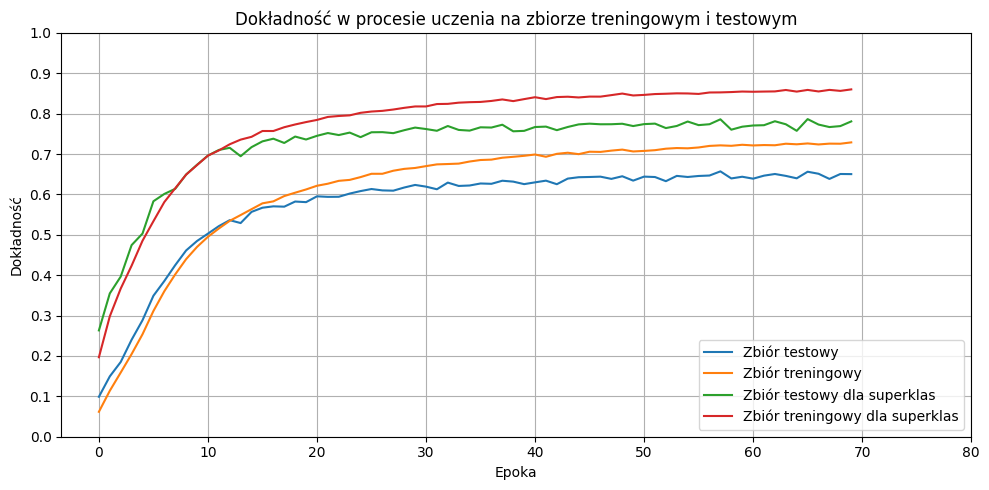

In [98]:
plt.figure(figsize=(10,5))
plt.title("Dokładność w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_acc[:81],label="Zbiór testowy")
plt.plot(train_acc[:81],label="Zbiór treningowy")
plt.plot(test_acc_super[:81],label="Zbiór testowy dla superklas")
plt.plot(train_acc_super[:81],label="Zbiór treningowy dla superklas")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.xticks(np.arange(0,81,10))
plt.yticks(np.arange(0.0,1.1,0.1))
plt.grid()
plt.legend()
plt.savefig('cifar100_doublecriterion25.png')
plt.tight_layout()
plt.show()

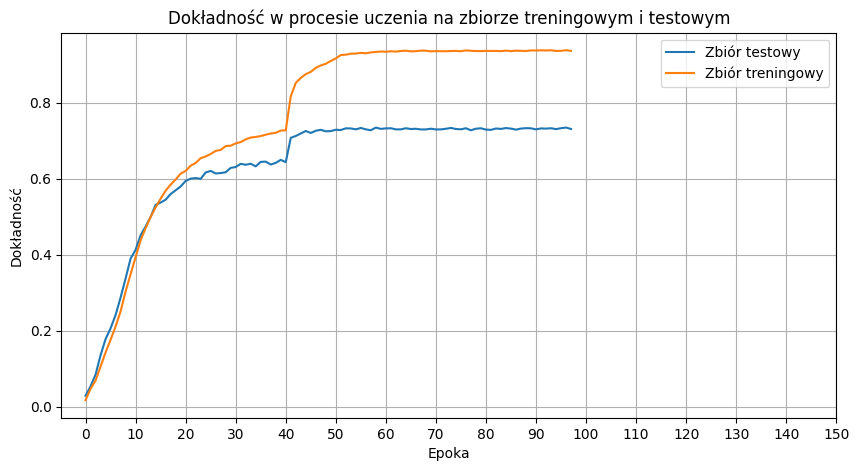

In [70]:
plt.figure(figsize=(10,5))
plt.title("Dokładność w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_acc[:151],label="Zbiór testowy")
plt.plot(train_acc[:151],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Dokładność")
plt.xticks(np.arange(0,151,10))
plt.grid()
plt.legend()
plt.savefig('cifar100_20classes_accuracyplot_I.png')
plt.show()

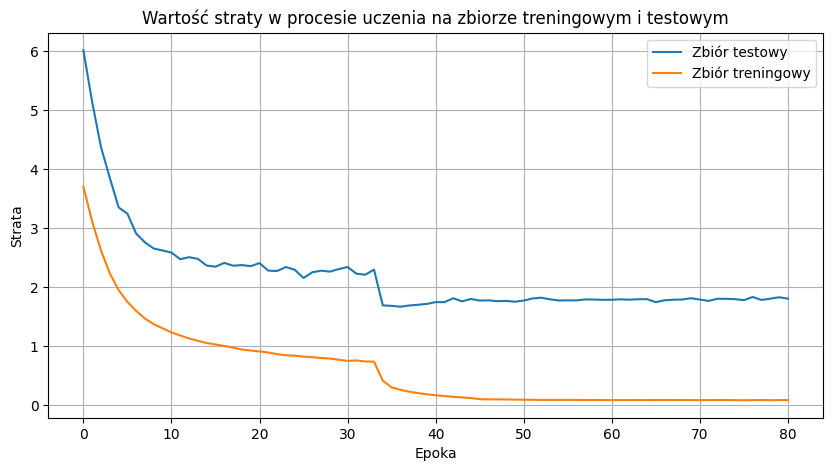

In [88]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:81],label="Zbiór testowy")
plt.plot(train_loss[:81],label="Zbiór treningowy")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,81,10))
plt.grid()
plt.legend()
plt.savefig('cifar100_loss_calkowite75.png')
plt.show()

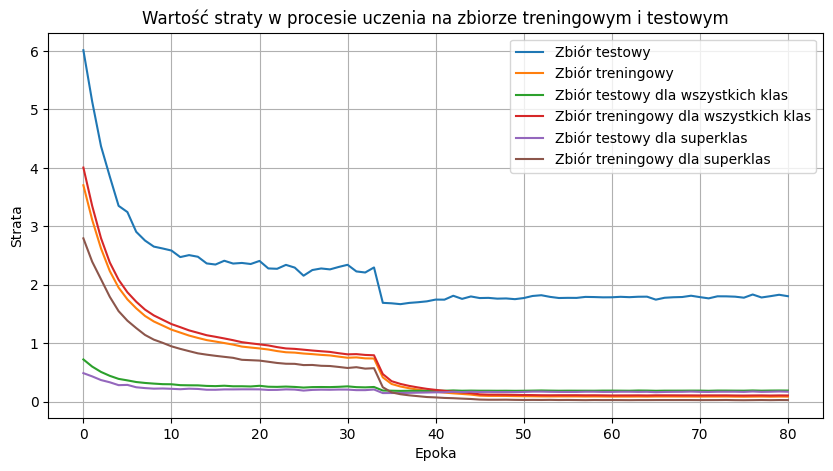

In [89]:
plt.figure(figsize=(10,5))
plt.title("Wartość straty w procesie uczenia na zbiorze treningowym i testowym")
plt.plot(test_loss[:81],label="Zbiór testowy")
plt.plot(train_loss[:81],label="Zbiór treningowy")
plt.plot(test_loss_class[:81],label="Zbiór testowy dla wszystkich klas")
plt.plot(train_loss_class[:81],label="Zbiór treningowy dla wszystkich klas")
plt.plot(test_loss_superclass[:81],label="Zbiór testowy dla superklas")
plt.plot(train_loss_superclass[:81],label="Zbiór treningowy dla superklas")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.xticks(np.arange(0,81,10))
plt.grid()
plt.legend()
plt.savefig('cifar100_loss_wszystkie75.png')
plt.show()

## Confusion matrix

In [ ]:
model.eval()
correct_test, total_test= 0, 0
all_preds = []
all_labels = []
with torch.no_grad():
    for (inputs, targets) in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

In [ ]:
all_preds_coarse=[]
for i in range(len(all_preds)):
    all_preds_coarse.append(train_data_20.fine_to_coarse[all_preds[i]])

all_labels_coarse=[]
for i in range(len(all_preds)):
    all_labels_coarse.append(train_data_20.fine_to_coarse[all_labels[i]])
    
cm=confusion_matrix(all_labels_coarse,all_preds_coarse)

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linecolor='black', linewidth=0.5)
plt.xlabel('Klasa przewidywana')
plt.ylabel('Klasa rzeczywista ')
plt.title('Macierz pomyłek')
plt.savefig('CM_100klas.png')
plt.show()

## Saving checkpoint separately

In [ ]:
model_save_path = '/kaggle/working/resnet_cifar100_' + str(87) + '.pth'
training_stats = {
  'epoch': epoch+1,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'scheduler_state_dict': scheduler.state_dict(),
  'loss': average_loss,
  'accuracy': accuracy,
  'test_accuracy': accuracy_test,
  'test_loss': average_loss_test,
  'learning_rate': optimizer.param_groups[0]["lr"]
}

In [ ]:
torch.save(training_stats, model_save_path)

# Retraining model for 100 classes

## Model setup

In [ ]:
saved_model_path='/kaggle/input/model-01/cifar100_20classes_ep53.pth'

In [ ]:
saved_model_path='/kaggle/input/pretrained-model/resnet_cifar100_transferlearningfor100clasep1415.pth'

In [ ]:
saved_model_path = '/kaggle/working/resnet_cifar100_87_20cl.pth'

In [ ]:
saved_model_path='/kaggle/input/premodel/resnet_cifar100_87_20cl.pth'

In [ ]:
saved_model_path='/kaggle/input/model25/resnet_cifar100_20classes_e25.pth'

In [ ]:
saved_model_path='/kaggle/working/models/resnet_cifar10_53.pth'

In [ ]:
model_test = resnet18(weights=None)

In [ ]:
model_test.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
model_test.maxpool=nn.Identity()
num_classes = 20
test_in_ftrs=model_test.fc.in_features
test_out_ftrs=model_test.fc.out_features
model_test.fc=nn.Linear(test_in_ftrs,num_classes)

## Model weights loading

In [ ]:
checkpoint = torch.load(saved_model_path)
model_test.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
for param in model_test.parameters():
    param.requires_grad = False

In [ ]:
for param in model_test.fc.parameters():
    param.requires_grad = True

In [ ]:
for name, param in model_test.named_parameters():
    print(name)

In [ ]:
for param in model_test.parameters():
    print(param.requires_grad)

In [ ]:
num_classes=100
model_test.fc = nn.Linear(test_in_ftrs, num_classes)

In [ ]:
model_test.to(device)

In [ ]:
model_test.eval().to(device)

### Evaluation for 20 classes

In [ ]:
model_test.eval()
correct_test, total_test= 0, 0
with torch.no_grad():
    for (inputs, targets) in test_dl_20:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_test(inputs)
        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

### Evaluation for 100 classes

In [ ]:
model_test.eval()
correct_test, total_test= 0, 0
with torch.no_grad():
    for (inputs, targets) in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_test(inputs)
        __, predicted = outputs.max(1)
        correct_test += predicted.eq(targets).sum().item()
        total_test+= targets.size(0)

accuracy_test = correct_test / total_test
accuracy_test_prc=accuracy_test*100
print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

## Optimizer, scheduler etc.

In [ ]:
max_lr=5e-2
momentum=0.9
weight_decay = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_test.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
max_lr=1e-2
momentum=0.9
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_test.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [ ]:
print([param.requires_grad for param in model_test.parameters()])

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr=5e-05)

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)

In [ ]:
 scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,55,60,80,120,140], gamma=0.1)

In [ ]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]
num_epochs=100
for epoch in range(num_epochs):
    model_test.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    data_loader = tqdm(test_dl, total=len(test_dl), desc=f'Epoch [{epoch + 1}/{num_epochs}]')

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model_test(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = outputs.max(1)
        correct_predictions += predicted.eq(targets).sum().item()
        total_samples += targets.size(0)

        # Progress bar description
        data_loader.set_postfix(loss=total_loss / (batch_idx + 1), accuracy=correct_predictions / total_samples)

    average_loss = total_loss / len(test_dl)
    accuracy = correct_predictions / total_samples
    
    train_loss.append(average_loss)
    train_acc.append(accuracy)
    
    model_test.eval()
    # test the model
    correct_test, total_test, total_loss_test = 0, 0, 0
    with torch.no_grad():
        for (inputs, targets) in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_test(inputs)
            loss = criterion(outputs, targets)
            total_loss_test += loss.item()

            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)

        accuracy_test = correct_test / total_test
        average_loss_test = total_loss_test / len(test_dl)
    
    test_loss.append(average_loss_test)
    test_acc.append(accuracy_test)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%, Loss on test data: {average_loss_test:.4f} Accuracy on test data: {100 * accuracy_test:.2f} %')

    model_save_path = '/kaggle/working/aftermodels/aftertl_100cl_ep' + str(epoch+1) + '.pth'
    training_stats = {
      'epoch': epoch+1,
      'model_state_dict': model_test.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'scheduler_state_dict': scheduler.state_dict(),
      'loss': average_loss,
      'accuracy': accuracy,
      'test_accuracy': accuracy_test,
      'test_loss': average_loss_test,
      'learning_rate': optimizer.param_groups[0]["lr"]
    }
        
    scheduler.step()
    torch.save(training_stats,model_save_path)

# Plots

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Testing Accuracy")
plt.plot(test_acc,label="Testing accuracy")
plt.plot(train_acc,label="Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Testing Loss")
plt.plot(test_loss,label="Testing loss")
plt.plot(train_loss,label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_test.eval()
ep=3
for e in range(ep):
    correct_test, total_test= 0, 0
    with torch.no_grad():
        for (inputs, targets) in test_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_test(inputs)
            __, predicted = outputs.max(1)
            correct_test += predicted.eq(targets).sum().item()
            total_test+= targets.size(0)

    accuracy_test = correct_test / total_test
    accuracy_test_prc=accuracy_test*100
    print(f'Accuracy on test data: {accuracy_test_prc:.2f} %')

In [ ]:
model_save_path = '/kaggle/working/resnet_cifar100_transferlearningfor100clasep14' + str(epoch+1) + '.pth'

In [ ]:
training_stats = {
  'epoch': epoch+1,
  'model_state_dict': model_test.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'scheduler_state_dict': scheduler.state_dict(),
  'loss': average_loss,
  'accuracy': accuracy,
  'test_accuracy': accuracy_test,
  'test_loss': average_loss_test,
  'learning_rate': optimizer.param_groups[0]["lr"]
}

In [ ]:
torch.save(training_stats, model_save_path)